In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
'''
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
'''

'\nimport numpy as np # linear algebra\nimport pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)\n\n# Input data files are available in the read-only "../input/" directory\n# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory\n\nimport os\nfor dirname, _, filenames in os.walk(\'/kaggle/input\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n\n# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" \n# You can also write temporary files to /kaggle/temp/, but they won\'t be saved outside of the current session\n'

In [2]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as rSquared
from keras.models import Sequential
from keras.layers import Conv2D, Dense

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, Concatenate,Input
from tensorflow.data import Dataset
from tensorflow.keras.models import Model

import cv2
from PIL import Image


2024-07-25 07:47:11.914028: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 07:47:11.914129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 07:47:12.033146: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
with open('/kaggle/input/hybrid-dataset-ver2/Hybrid_trainset2.pkl','rb') as f:
    train = pickle.load(f)

with open('/kaggle/input/hybrid-dataset-ver2/Hybrid_testset2.pkl','rb') as f:
    test = pickle.load(f)

In [4]:
image_size=224


X_train_img = np.array([item[0] for item in train]).reshape(-1,image_size,image_size,3)*(1./255)
X_test_img = np.array([item[0] for item in test]).reshape(-1,image_size,image_size,3)*(1./255)

y_train = np.array([item[1] for item in train]).reshape(-1)
y_test = np.array([item[1] for item in test]).reshape(-1)

X_train_auxiliary1 = np.array([item[2] for item in train]).reshape((len(train)),1)
X_test_auxiliary1= np.array([item[2] for item in test]).reshape((len(test)),1)

X_train_auxiliary2 = np.array([item[3] for item in train]).reshape((len(train)),1)
X_test_auxiliary2= np.array([item[3] for item in test]).reshape((len(test)),1)

X_train_auxiliary3 = np.array([item[4] for item in train]).reshape((len(train)),1)
X_test_auxiliary3= np.array([item[4] for item in test]).reshape((len(test)),1)

X_train_auxiliary4 = np.array([item[5] for item in train]).reshape((len(train)),1)
X_test_auxiliary4= np.array([item[5] for item in test]).reshape((len(test)),1)

X_train_auxiliary5 = np.array([item[6] for item in train]).reshape((len(train)),1)
X_test_auxiliary5= np.array([item[6] for item in test]).reshape((len(test)),1)

X_train_auxiliary6 = np.array([item[7] for item in train]).reshape((len(train)),18,1)
X_test_auxiliary6 = np.array([item[7] for item in test]).reshape((len(test)),18,1)

In [5]:
np.shape(X_train_auxiliary6)

(700, 18, 1)

**Building the Model**

In [6]:
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Flatten, LSTM, concatenate,MaxPooling2D,Dropout


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Define inputs
image_input=Input(shape=(224,224,3))

# Pass the image input through the base model
x = base_model(image_input)
x = Flatten()(x)

auxiliary_input1=Input(shape=(1,))
auxiliary_input2=Input(shape=(1,))
auxiliary_input3=Input(shape=(1,))
auxiliary_input4=Input(shape=(1,))
auxiliary_input5=Input(shape=(1,))
auxiliary_input6=Input(shape=(18,))


combined_input=concatenate([x,auxiliary_input1,auxiliary_input2,auxiliary_input3,auxiliary_input4,auxiliary_input5,auxiliary_input6])
x=Dense(128, activation='relu')(combined_input)
x=Dense(64, activation='relu')(x)
z=Dense(1, activation='linear')(x)
model = Model(inputs=[image_input,auxiliary_input1,auxiliary_input2,auxiliary_input3,auxiliary_input4,auxiliary_input5,auxiliary_input6], outputs=z)


In [8]:
x[0]

<KerasTensor shape=(64,), dtype=float32, sparse=False, name=keras_tensor_32>

In [9]:
# Compile the model
model.compile(optimizer='adam', loss='mae', metrics=['mae'],run_eagerly=True)
early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1)

In [10]:
epochsize = 120
#model = model.fit(X_train, y_train, validation_split= 0.1,epochs=10, batch_size = 100, callbacks=[early_stop],verbose= 1,shuffle=False)
history = model.fit(x=[X_train_img,X_train_auxiliary1,X_train_auxiliary2,X_train_auxiliary3,X_train_auxiliary4,X_train_auxiliary5,X_train_auxiliary6], y=y_train, validation_split= 0.1,epochs=epochsize, batch_size=100, callbacks=[early_stop],verbose= 1,shuffle=False)

Epoch 1/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - loss: 7.5302 - mae: 7.5302 - val_loss: 4.6221 - val_mae: 4.6221
Epoch 2/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 847ms/step - loss: 4.3653 - mae: 4.3653 - val_loss: 3.8849 - val_mae: 3.8849
Epoch 3/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 847ms/step - loss: 3.3318 - mae: 3.3318 - val_loss: 3.1520 - val_mae: 3.1520
Epoch 4/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 848ms/step - loss: 2.6543 - mae: 2.6543 - val_loss: 2.7768 - val_mae: 2.7768
Epoch 5/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 847ms/step - loss: 2.2301 - mae: 2.2301 - val_loss: 2.4656 - val_mae: 2.4656
Epoch 6/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 846ms/step - loss: 1.8479 - mae: 1.8479 - val_loss: 2.8541 - val_mae: 2.8541
Epoch 7/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 847ms/step - loss: 1.8555 - mae: 1.8555 - val_loss: 2.3036 - val_mae: 2.3036
Epoch 8/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 847ms/step - loss: 1.6101 - mae: 1.6101 - val_loss: 2.1060 - val_mae: 2.1060
Epoch 9/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 849ms/step - loss: 1.4349 

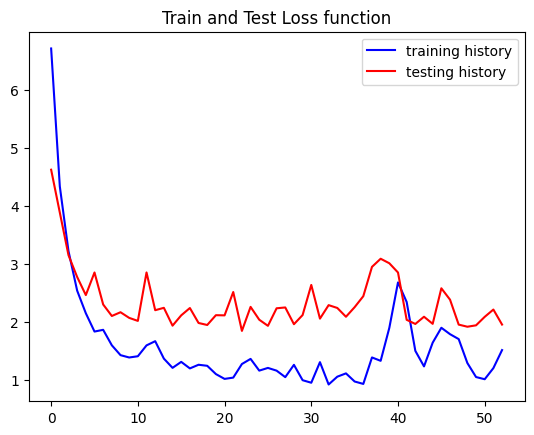

In [11]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'],'b', label='training history')
pyplot.plot(history.history['val_loss'],'r',label='testing history')
pyplot.title("Train and Test Loss function")
pyplot.legend()
pyplot.show()

In [12]:
loss = model.evaluate([X_test_img,X_test_auxiliary1,X_test_auxiliary2,X_test_auxiliary3,X_test_auxiliary4,X_test_auxiliary5,X_test_auxiliary6],y_test)
#accuracy = model.evaluate(X_test, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 809ms/step - loss: 1.8053 - mae: 1.8053


In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 25111)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ input_layer_2[0]… │
│                     │                   │            │ input_layer_3[0]… │
│                     │                   │            │ input_layer_4[0]… │
│                     │                   │            │ input_layer_5[0]… │
│                     │                   │            │ input_layer_6[0]… │
│                     │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  3,214,336 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,382,661 (93.01 MB)

 Trainable params: 3,222,657 (12.29 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 6,445,316 (24.59 MB)

In [14]:
from sklearn.metrics import mean_absolute_percentage_error as mape

y_pred1 = model.predict([X_test_img,X_test_auxiliary1,X_test_auxiliary2,X_test_auxiliary3,X_test_auxiliary4,X_test_auxiliary5,X_test_auxiliary6])
y_pred = y_pred1.reshape(-1)
MAE=mae(y_test,y_pred)
RMSE=mse(y_test,y_pred,squared=False)
MAPE=mape(y_test,y_pred)
R2=rSquared(y_test,y_pred)

print("Mean Absolute Error:", MAE)
print("Root Mean Squared Error:", RMSE)
print("Mean Absolute Precentage Error",MAPE)
print("Coefficient of determination ",R2)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Mean Absolute Error: 1.7398178760705751
Root Mean Squared Error: 2.817739524900997
Mean Absolute Precentage Error 0.17060084964951985
Coefficient of determination  0.8468131403129432


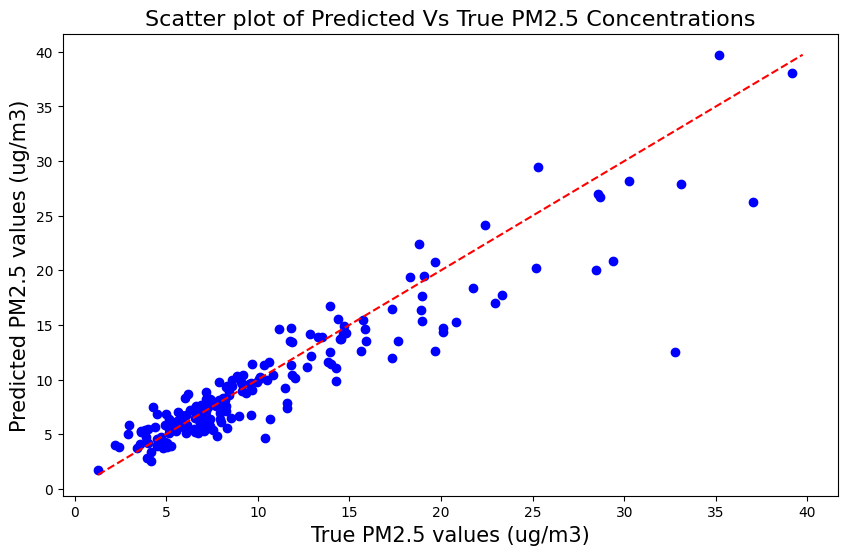

In [15]:
plt.figure(figsize=(10, 6))

# Plotting y_test values
plt.scatter( y_test,y_pred, c='blue', label='True Values')

max_value = max(max(y_test), max(y_pred))
min_value = min(min(y_test), min(y_pred))
plt.plot([min_value, max_value], [min_value, max_value], color='red',linestyle='dashed',label='Reference line')


plt.ylabel('Predicted PM2.5 values (ug/m3)', fontsize=15)
plt.xlabel('True PM2.5 values (ug/m3)', fontsize=15)
plt.title('Scatter plot of Predicted Vs True PM2.5 Concentrations', fontsize=16)
#plt.legend()
#plt.title("Scatter plot of Predicted Vs True PM2.5 Concentrations")
plt.show()


In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Function to calculate permutation importance
def permutation_importance(model, X_test_img, X_test_auxiliary, y_test, n_repeats=10):
    baseline_preds = model.predict([X_test_img] + X_test_auxiliary)
    baseline_score = mean_squared_error(y_test, baseline_preds)
    
    importances = []
    for i in range(len(X_test_auxiliary)):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X_test_auxiliary[i].copy()
            np.random.shuffle(X_permuted)
            permuted_preds = model.predict([X_test_img] + X_test_auxiliary[:i] + [X_permuted] + X_test_auxiliary[i+1:])
            score = mean_squared_error(y_test, permuted_preds)
            scores.append(score)
        importances.append(np.mean(scores) - baseline_score)
    
    return importances

# Example usage
X_test_auxiliary = [X_test_auxiliary1, X_test_auxiliary2, X_test_auxiliary3, X_test_auxiliary4, X_test_auxiliary5,X_test_auxiliary6]
X_auxiliary_labels=['GreenIndex','UrbanIndex','NearRoad','Season','IsWeek','LSTMHistory']
importances = permutation_importance(model, X_test_img, X_test_auxiliary, y_test)

# Print feature importances
for i, importance in enumerate(importances):
    print(f"Feature {i+1} importance: {importance}")
    



6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━

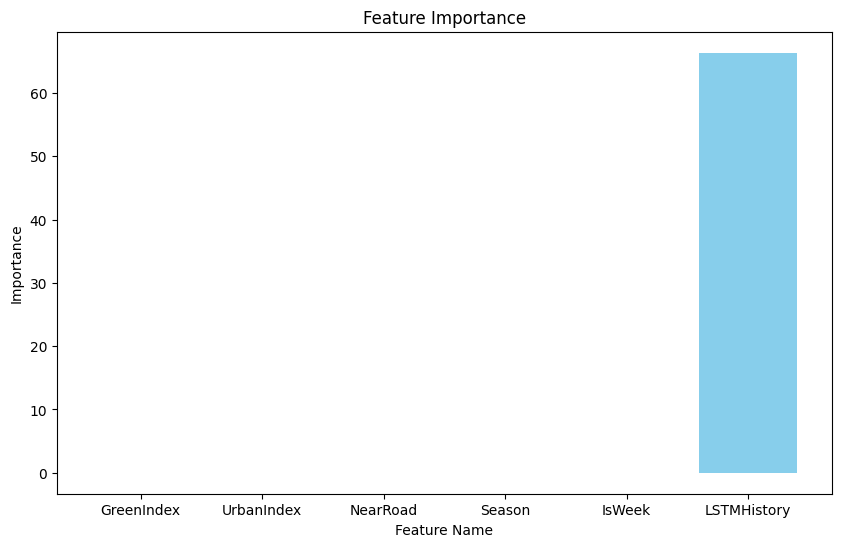

In [21]:
import matplotlib.pyplot as plt

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(X_auxiliary_labels, importances, color='skyblue')
plt.xlabel('Feature Name')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()